In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.linear_model import LinearRegression

C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
location="D:\s_chernov\AnacondaProjects\SberHouse\Data\\"
tr=pd.read_csv(location+"train.csv",sep=',')
tst=pd.read_csv(location+"test.csv",sep=',')
macro=pd.read_csv(location+"sample_submission.csv",sep=',')
cheat=pd.read_csv(location+"sqprice.csv",sep=';')
prices=pd.read_csv(location+"dynamic_prices.csv",sep=';')
prices.head()

,year_month,mean_price
0,2015_1,196000
1,2015_2,200000
2,2015_3,205000
3,2015_4,180000
4,2015_5,180000


In [3]:
from dateutil.parser import parse

dfDateTime=tr["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tr['year']=year
tr['month']=month
tr['day']=day

dfDateTime=tst["timestamp"]
b=map(parse,dfDateTime)
year=map(lambda x:x.year,b)
month=map(lambda x:x.month,b)
day=map(lambda x:x.day,b)
tst['year']=year
tst['month']=month
tst['day']=day

In [4]:
tr['year_month']=map(lambda x,y:str(x)+"_"+str(y),tr.year,tr.month)
tst['year_month']=map(lambda x,y:str(x)+"_"+str(y),tst.year,tst.month)

tr=pd.merge(tr, prices, how='left', on=['year_month', 'year_month'])
tst=pd.merge(tst, prices, how='left', on=['year_month', 'year_month'])

In [5]:
#tr=pd.concat([tr, cheat], axis=1, join='outer')
#tst=pd.concat([tr, cheat], axis=1, join='outer')

tr=pd.merge(tr, cheat, how='left', on=['sub_area', 'sub_area'])
tst=pd.merge(tst, cheat, how='left', on=['sub_area', 'sub_area'])

tr.loc[:,'cheat']=np.sqrt(tr.full_sq*tr.feb16+1)
tst.loc[:,'cheat']=np.sqrt(tst.full_sq*tst.feb16+1)





In [6]:
tr=tr.drop('timestamp',axis=1)
tst=tst.drop('timestamp',axis=1)

In [7]:
tr.material=np.int64(tr.material)
tst.material=np.int64(tst.material)

In [8]:
#features by type
response='price_doc'

tr_type=(tr.dtypes==np.float64)|(tr.dtypes==np.int64)
dig_features=list(tr.loc[:,tr_type].columns)
dig_features.remove(response)
tr_type=(tr.dtypes==np.object)
obj_features=list(tr.loc[:,tr_type].columns)

tr2=tr.loc[tr.year==2015]


In [9]:
# not finished building
a=tr2.build_year-tr2.year
a[(a.isnull())|(a<0)]=0
tr2['y_build']=a

a=tst.build_year-tst.year
a[(a.isnull())|(a<0)]=0
tst['y_build']=a

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
a=(tr2.y_build>0).apply(int)
tr2['flag_build']=a
a=(tst.y_build>0).apply(int)
tst['flag_build']=a

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
#___price and floor error

#print tst.loc[(tst.floor>tst.max_floor),['id','full_sq','floor','max_floor','sub_area']]

#_____price error
#print tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000),['id','full_sq','price_doc','sub_area']].index
tr2=tr2.drop( tr2.loc[(tr2.full_sq>180) &(tr2.price_doc<10000000)].index)

#___max_floor error
tr2=tr2.drop(tr2.loc[(tr2.floor>tr2.max_floor)].index)
correct=tst.loc[(tst.floor>tst.max_floor)].index
tst.loc[correct,'max_floor']=tst.floor[correct]+1
tr2=tr2.drop(tr2.loc[(tr2.num_room==0)].index)


In [12]:
#___square and num_room error
#print tr2.loc[(tr2.full_sq==64),['id','full_sq','num_room','price_doc','sub_area']]

tr2.loc[28867,'num_room']=1
tr2.loc[29172,'num_room']=2

tst.loc[464,'full_sq']=42
tst.loc[3500,'full_sq']=50
tst.loc[6350,'full_sq']=50
tst.loc[5383,'full_sq']=64
tst.loc[3174,'num_room']=1
tst.loc[6003,'num_room']=1
tst.loc[6181,'num_room']=2
tst.loc[7213,'num_room']=1
tst.loc[7313,'num_room']=1
tst.loc[1417,'num_room']=1
tst.loc[1429,'num_room']=1

#print tr2.loc[(tr2.full_sq/tr2.num_room<15),['id','full_sq','num_room','price_doc','sub_area']]
print tst.loc[(tst.full_sq/tst.num_room<15),['id','full_sq','num_room','sub_area']]


         id  full_sq  num_room            sub_area
2804  33278     14.8         1  Chertanovo Juzhnoe


In [13]:
#_________kitchen error

correct=tst.loc[(tst.kitch_sq/tst.full_sq>0.5)].index
tst.at[correct,'kitch_sq']=8

correct=tr2.loc[(tr.kitch_sq/tr.full_sq>0.5)].index
tr2.at[correct,'kitch_sq']=8

#print tst.loc[(tst.kitch_sq/tst.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]
#print tr2.loc[(tr2.kitch_sq/tr2.full_sq>0.5),['id','full_sq','kitch_sq','sub_area']]

#state error

tr2.at[tr2.state.isnull(),'state']=2
tst.at[tst.state.isnull(),'state']=2


In [14]:
#______last and first floor

tr2.loc[:,'first']=(tr2.floor==1).apply(int)
tr2.loc[:,'last']=(tr2.floor==tr2.max_floor).apply(int)
tst.loc[:,'first']=(tst.floor==1).apply(int)
tst.loc[:,'last']=(tst.floor==tst.max_floor).apply(int)


tr2.loc[:,'floor_low']=(tr2.floor<5).apply(int)
tst.loc[:,'floor_low']=(tst.floor<5).apply(int)

tr2.loc[:,'floor_5']=(tr2.floor==5).apply(int)
tst.loc[:,'floor_5']=(tst.floor==5).apply(int)

tr2.loc[:,'floor_9']=(tr2.floor==9).apply(int)
tst.loc[:,'floor_9']=(tst.floor==9).apply(int)

tr2.loc[:,'floor_12']=(tr2.floor==12).apply(int)
tst.loc[:,'floor_12']=(tst.floor==12).apply(int)

tr2.loc[:,'floor_13_18']=((tr2.max_floor>12) & (tr2.max_floor<=18)).apply(int)
tst.loc[:,'floor_13_18']=((tst.max_floor>12) & (tst.max_floor<=18)).apply(int)

tr2.loc[:,'floor_high']=(tr2.floor>18).apply(int)
tst.loc[:,'floor_high']=(tst.floor>15).apply(int)


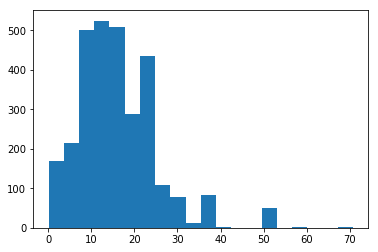

In [15]:
tr2.loc[:,'kremlin_near']=(tr2.kremlin_km<3).apply(int)
tst.loc[:,'kremlin_near']=(tst.kremlin_km<3).apply(int)

tr2.loc[:,'kremlin_1_5']=((tr2.kremlin_km>=1) & (tr2.kremlin_km<=5)).apply(int)
tst.loc[:,'kremlin_1_5']=((tst.kremlin_km>=1) & (tst.kremlin_km<=5)).apply(int)

tr2.loc[:,'kremlin_5_10']=((tr2.kremlin_km>5) & (tr2.kremlin_km<10)).apply(int)
tst.loc[:,'kremlin_5_10']=((tst.kremlin_km>5) & (tst.kremlin_km<10)).apply(int)


plt.hist(tr2.kremlin_km,20)
plt.show()

In [16]:
# month bool?
def make_dummies(pref,source,var_name):
    for i in var_name:
        dummies = pd.get_dummies(source[i],prefix=pref)
        source=pd.concat([source,dummies],axis=1)
    return source.drop(var_name,axis=1)

tr_back_up=tr2
tst_back_up=tst

tr2=make_dummies('mat',tr_back_up,['material'])
tst=make_dummies('mat',tst_back_up,['material'])



In [17]:
#ownership

tr2.loc[:,'own']=(tr2.product_type=='OwnerOccupier').apply(int)
tst.loc[:,'own']=(tst.product_type=='OwnerOccupier').apply(int)

#poselenie
#area_mo='Poselenie|Silino|Troickij okrug|Matushkino|Savelki|Severnoe|Vnukovo'
area_mo='Poselenie'


tr2.loc[:,'poselok']=tr2.sub_area.str.contains(area_mo).apply(int)
tst.loc[:,'poselok']=tst.sub_area.str.contains(area_mo).apply(int)

#radiation

tr2.loc[:,'radiate']=(tr2.radiation_raion=='yes').apply(int)
tst.loc[:,'radiate']=(tst.radiation_raion=='yes').apply(int)



In [18]:
tst.columns

Index([u'id', u'full_sq', u'life_sq', u'floor', u'max_floor', u'build_year',
       u'num_room', u'kitch_sq', u'state', u'product_type',
       ...
       u'kremlin_5_10', u'mat_1', u'mat_2', u'mat_3', u'mat_4', u'mat_5',
       u'mat_6', u'own', u'poselok', u'radiate'],
      dtype='object', length=318)

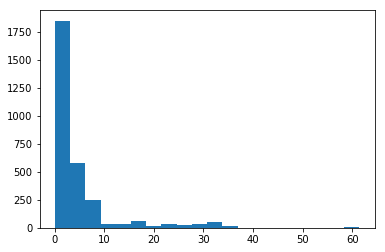

In [19]:
plt.hist((tr2.metro_min_avto),20)
plt.show()

#___metro features
tr2.loc[:,'metro_near']=(tr2.metro_min_avto<=3.4).apply(int)
tst.loc[:,'metro_near']=(tst.metro_min_avto<=3.4).apply(int)
tr2.loc[:,'metro_far']=(tr2.metro_min_avto>=20).apply(int)
tst.loc[:,'metro_far']=(tst.metro_min_avto>=20).apply(int)


In [34]:
from sklearn.model_selection import train_test_split


features=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','kremlin_near','kremlin_1_5','kremlin_5_10','mean_price',
          'own','metro_near','metro_far','poselok','radiate','indust_part','kindergarten_km',
          'mat_1','mat_2','mat_4','mat_5','mat_6']

features_mos=['num_room','full_sq','kitch_sq','floor','first','last',
          'floor_low','floor_5','floor_9','floor_12','floor_13_18','floor_high',
          'state','ttk_km','kremlin_1_5','indust_part','feb16','cheat',
          'own','metro_near','mean_price',
              'mat_1','mat_2','mat_4','mat_5',
             'green_zone_km','kindergarten_km','flag_build']

features_pos=['num_room','full_sq','first','last',
          'floor_12','mkad_km','metro_min_avto','indust_part','mean_price','kindergarten_km','railroad_km',
             'mat_1','mat_2','mat_4','mat_5','y_build']

np.random.seed(123)



#y_train_mos=np.sqrt(y_train_mos)
#y_test_mos=np.sqrt(y_test_mos)

In [35]:
alph_regr=1
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
#poselok linear
#fit2= LinearRegression()


In [36]:
tr_pos=tr2[tr2.poselok==1]
tst_pos=tst[tst.poselok==1]

y_train_pos=np.sqrt(y_train_pos)
y_test_pos=np.sqrt(y_test_pos)

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(tr_pos.loc[:,features_pos], tr_pos.price_doc, test_size=0.33, random_state=42)

dtrain = xgb.DMatrix(X_train_pos, y_train_pos, feature_names=features_pos)
dval = xgb.DMatrix(X_test_pos, y_test_pos, feature_names=features_pos)

In [37]:
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

#partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000)

pred = partial_model.predict(dval)
print '________________'
print r2_score (y_test_pos,list(pred))
print len(pred),min(pred),max(pred)
print len(y_test_pos),min(y_test_pos),max(y_test_pos)

best_pos = partial_model.best_iteration
partial_model.get_score()

[0]	val-rmse:6.0315e+06
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:2.47172e+06
[40]	val-rmse:1.31005e+06
[60]	val-rmse:996294
[80]	val-rmse:909648
[100]	val-rmse:880204
[120]	val-rmse:863172
[140]	val-rmse:853833
[160]	val-rmse:850082
[180]	val-rmse:847334
[200]	val-rmse:845605
[220]	val-rmse:844257
[240]	val-rmse:842720
[260]	val-rmse:842767
[280]	val-rmse:842575
Stopping. Best iteration:
[269]	val-rmse:841844

________________
0.852755548484
260 1.89852e+06 1.01639e+07
260 990000 15043290


{'first': 137,
 'floor_12': 90,
 'full_sq': 1314,
 'indust_part': 173,
 'kindergarten_km': 658,
 'last': 92,
 'mat_1': 103,
 'mat_2': 17,
 'mat_4': 75,
 'mat_5': 51,
 'mean_price': 489,
 'metro_min_avto': 638,
 'mkad_km': 755,
 'num_room': 308,
 'railroad_km': 660,
 'y_build': 111}

In [53]:
tr_mos=tr2[(tr2.poselok==0)]
tst_mos=tst[tst.poselok==0]
#tr_mos=tr2[(tr2.poselok==0)&(tr2.month>1)]
X_train_mos, X_test_mos, y_train_mos, y_test_mos = train_test_split(tr_mos.loc[:,features_mos], tr_mos.price_doc, test_size=0.33, random_state=42)


In [57]:
dtrain = xgb.DMatrix(X_train_mos, y_train_mos, feature_names=features_mos)
dval = xgb.DMatrix(X_test_mos, y_test_mos, feature_names=features_mos)
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000, evals=[(dval, 'val')],
                       early_stopping_rounds=20, verbose_eval=20)

#partial_model = xgb.train(xgb_params, dtrain, num_boost_round=1000)

pred = partial_model.predict(dval)
print '________________'
print r2_score (y_test_mos,list(pred))
print len(pred),min(pred),max(pred)
print len(y_test_mos),min(y_test_mos),max(y_test_mos)

best_mos = partial_model.best_iteration
partial_model.get_score()

[0]	val-rmse:1.0286e+07
Will train until val-rmse hasn't improved in 20 rounds.
[20]	val-rmse:4.96956e+06
[40]	val-rmse:3.58048e+06
[60]	val-rmse:3.22824e+06
[80]	val-rmse:3.12537e+06
[100]	val-rmse:3.09285e+06
[120]	val-rmse:3.08788e+06
[140]	val-rmse:3.0778e+06
[160]	val-rmse:3.06135e+06
[180]	val-rmse:3.06033e+06
Stopping. Best iteration:
[162]	val-rmse:3.05895e+06

________________
0.739696150665
724 3.02217e+06 5.80201e+07
724 976000 70000000


{'cheat': 372,
 'feb16': 196,
 'first': 4,
 'flag_build': 4,
 'floor': 254,
 'floor_12': 3,
 'floor_13_18': 23,
 'floor_5': 33,
 'floor_9': 11,
 'floor_high': 5,
 'floor_low': 16,
 'full_sq': 475,
 'green_zone_km': 297,
 'indust_part': 215,
 'kindergarten_km': 317,
 'kitch_sq': 228,
 'kremlin_1_5': 27,
 'last': 30,
 'mat_1': 25,
 'mat_2': 11,
 'mat_4': 32,
 'mat_5': 2,
 'mean_price': 63,
 'metro_near': 36,
 'num_room': 215,
 'own': 10,
 'state': 120,
 'ttk_km': 427}

In [66]:
#3BOOST for pos 
#fit = LinearRegression()
X=tr2.loc[tr2.poselok==1,features_pos]
Y=np.sqrt(tr2.loc[tr2.poselok==1,'price_doc'])
dtrain_all = xgb.DMatrix(X, Y, feature_names=features_pos)
dtest_all = xgb.DMatrix(tst.loc[tst.poselok==1,features_pos])


fit = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=best_pos)

pred_pos = fit.predict(dtest_all)
pred_pos=pred_pos**2
#pred_pos[pred_pos<900000]=900000

print len(pred_pos),min(pred_pos),max(pred_pos)
print len(Y),min(Y),max(Y)


1575 1.90007e+06 1.08654e+07
785 994.987437107 3878.56803473


In [67]:
#3BOOST for mos 
X=tr2.loc[tr2.poselok==0,features_mos]
Y=np.sqrt(tr2.loc[tr2.poselok==0,'price_doc'])
dtrain_all = xgb.DMatrix(X, Y, feature_names=features_mos)
dtest_all = xgb.DMatrix(tst.loc[tst.poselok==0,features_mos])

fit = xgb.train(dict(xgb_params, silent=0), dtrain_all, num_boost_round=best_mos)
pred_mos = fit.predict(dtest_all)
pred_mos=pred_mos**2
#pred_pos[pred_pos<900000]=900000

print len(pred_mos),min(pred_mos),max(pred_mos)
print len(Y),min(Y),max(Y)



6087 1.51522e+06 5.01316e+07
2193 707.106781187 9753.07623266


In [68]:
res1=pd.DataFrame({'id':tst.loc[tst.poselok==1,'id'],'price_doc':(pred_pos)})
#print res1.describe()

res2=pd.DataFrame({'id':tst.loc[tst.poselok==0,'id'],'price_doc':(pred_mos)})
#print res2.describe()
res=pd.concat([res1,res2])
del res1,res2

In [69]:
#pd.DataFrame({'id':tst.id,'price_doc':(pred)}).to_csv(location+'submission.csv',sep=',',index=False)
res.to_csv(location+'submission2.csv',sep=',',index=False)


In [70]:
np.random.seed(123)


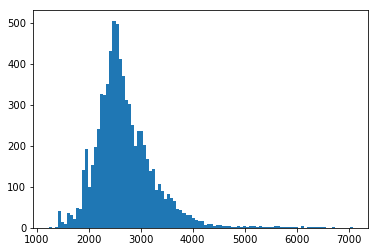

In [72]:
plt.hist(np.sqrt(res.price_doc),100)
plt.show()
